# Discharge, Reaccretion, and impacts of Supernovae (Part 1 /?):
## Concerning Satellite Infall
`-- Leo Lonzarich, 27 January 2022 // [Updated 17-2-22] --`

---

### Table of Contents
- [Defining Infall](#infall)
    - [Discharge and Reaccretion](#disreacc)
    - [Identifying Ram Pressures](#ramdis)
- [SN-heating Gas Fractions](#gasfrac)
    - [Discharged/Reaccreted](#reaccreted)
    - [DIscharged/All](#discharged)
- [Other](#other)


   




### General Comments on Data/Contents of this Noteboook
- This is the first installment of work tied to Spring 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `heated`: Gas particles in `discharged` that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from `discharged` with `sneHeated==True`.)
- `preheated`: Similar to `predischarged`; Consists of the same particles in `heated`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)


In [2]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import *
from ramdischarge import *

In [3]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
# quick check to ensure all selected gas particles are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


## Establishing Infall Distance to Satellite Host  <a class="anchor" id="infall"></a>

#### Why?

To kickoff the second stage in SNe feedback analysis, we are first required to identify location during satellite infall for each gas particle. When a distant dwarf galaxy becomes gravitationally bound to a Milky-Way-mass host galaxy, it develops an approach vector oriented towards the COM of the host -- it is this approach to the host COM that we term "satellite infall", and it is the distance of the satellite's COM to the host's COM that we define as "point at infall". 

Thus, for each gas particle, we wish to find point at infall with the end goal being that this allows us to more readily discriminate between gas particles. What is more, however, we know from past work (see Akins et al. 2021) that ram pressure stripping (RPS) efficiency increases with proximity of a satellite galaxy to its host. Therefore, discriminating on point at infall presents a method for screening gas for RPS and possibly untangle RPS from SNe feedback stripping mechanisms.

#### How? 

Locating point at infall data, which we will lovingly term PAI (or `pai`), is a relatively straightforward excercise, and we will normalize `pai` by the virial radius of the host galaxy, `Rvir`, which will effectively give us a percent distance of a gas particle's satellite to the center of its host:

$$
pai = \frac{\text{radial distance from sat. to host}}{\text{virial radius of host}} .
$$
____
____

### Effects of POI on Discharge, Reaccretion  <a class="anchor" id="disreacc"></a>

___

In [6]:
# importing gas selection:
predischarged, discharged, preheated, heated = read_all_discharged()
accreted, reaccreted = read_accreted()

> Returning (predischarged, discharged, preheated, heated) for all satellites <
> Returning (accreted, reaccreted) for all satellites <


In [7]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'sneHeated', 'key'],
      dtype='object')

In [8]:
# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2 
                            + (gas['host_Yc'] - gas['sat_Yc'])**2 
                            + (gas['host_Zc'] - gas['sat_Zc'])**2 
                           )/ gas['hostRvir']
                   )

# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

Notes on terminology:
- We use $\sum M_{dsrg}$ and $\sum M_{reacc}$ to denote the cumulative mass of all discharged and reaccreted gas particles, respectively.
- $R_{vir}$ is the virial radius of the host galaxy.
- $M_{\{gas\}}$ refers to the mass of gas either discharged or reaccreted (where applicable in the plots) corresponding to a particular parameter.

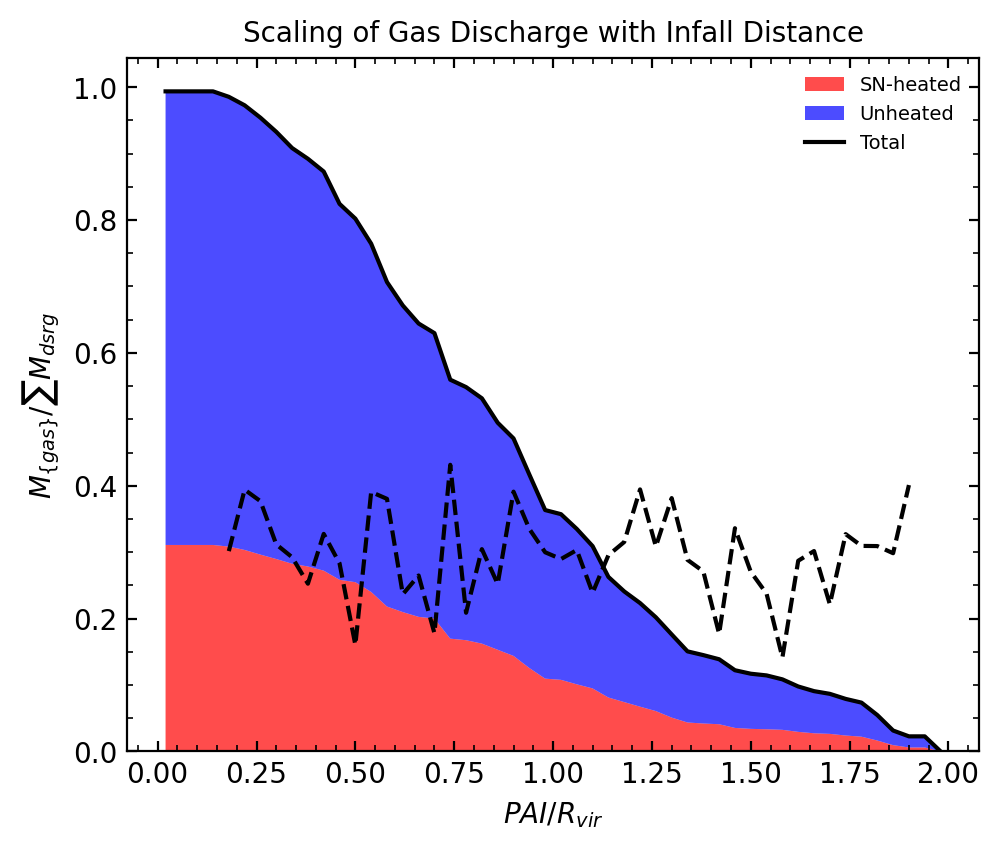

In [22]:
# where discharged gas is removed to as a function of PAI.
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]


bins = 50
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters, y1/y3, linestyle='--', c='black')

ax.set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

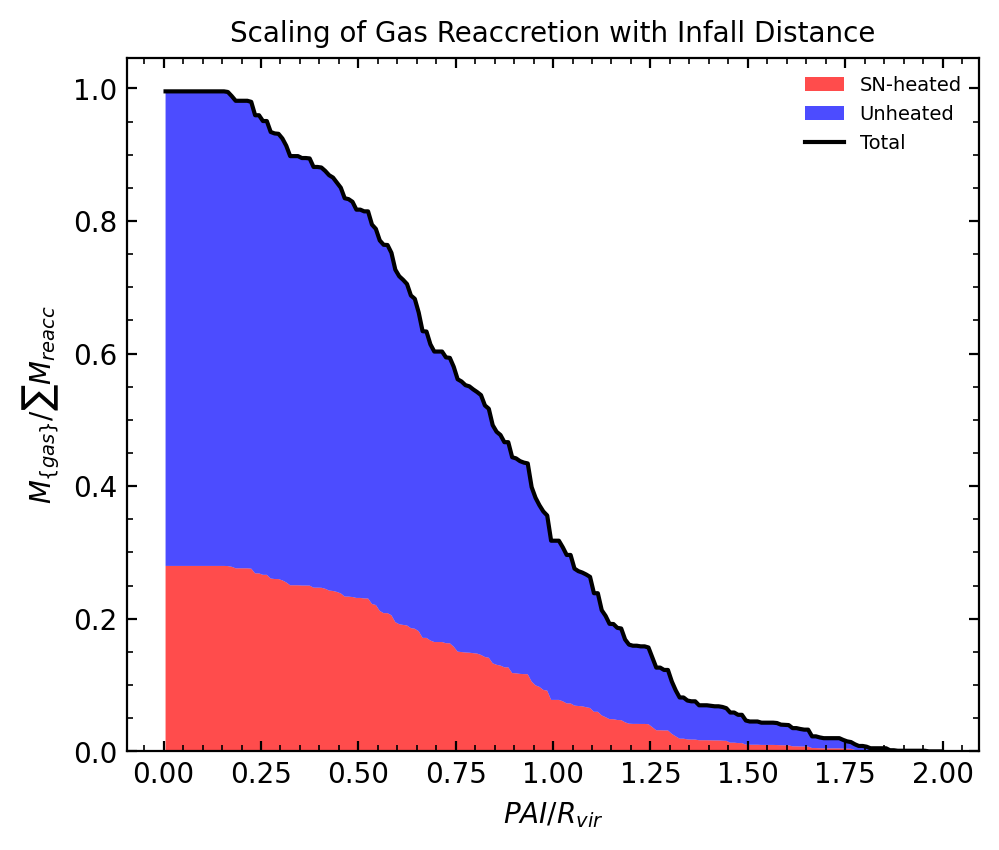

In [8]:
# Basic visualization of where reaccreted gas is removed to as function of POI.
hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), 
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.set_title('Scaling of Gas Reaccretion with Infall Distance',
             fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{reacc}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

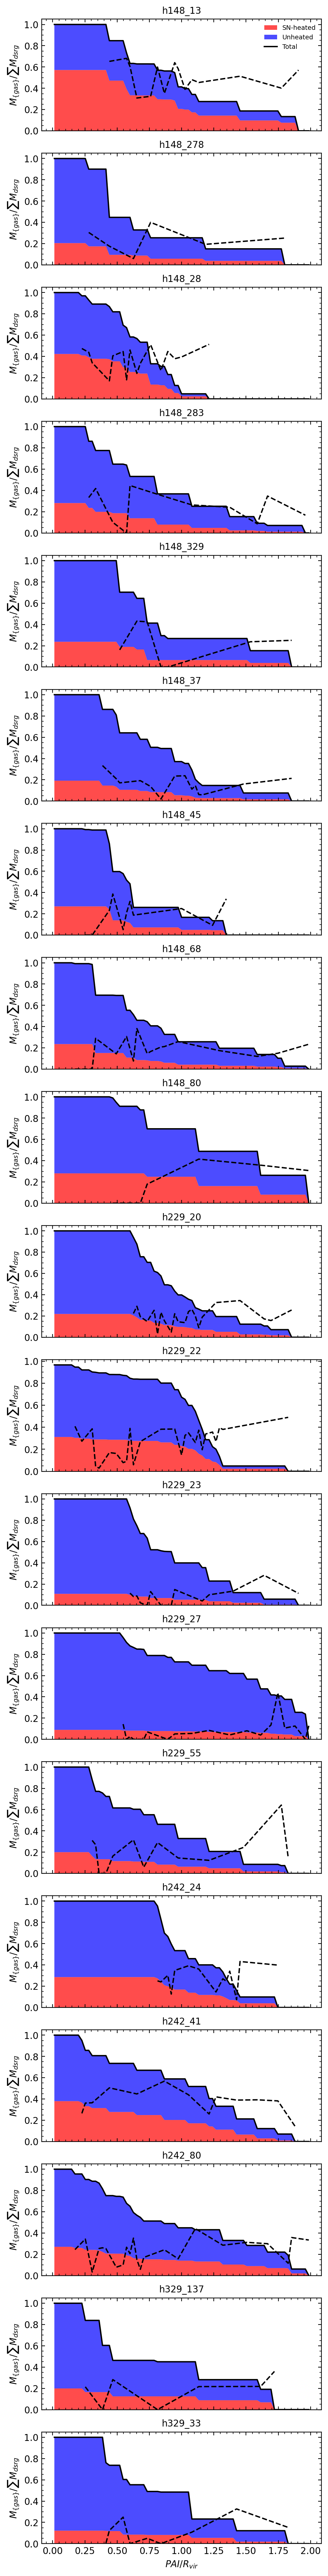

In [29]:
# Making panels of the discharge plots above for each satellite.

# where discharged gas is removed to as a function of PAI.
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]


# running loop for each sat.
bins = 75
fig, ax = plt.subplots(19, 1, dpi=200, figsize=(5.5,50), sharex=True,
                       constrained_layout=False)

for i in range(0,len(keys)):
    key = keys[i]
    hot1 = hot[hot['key']==key]
    cold1 = cold[cold['key']==key]
    discharged1 = discharged[discharged['key']==key]
    
    y1, x = np.histogram(pai(hot1), bins=bins, weights=wt(hot1,discharged1),
                         range=(0, 2))
    bincenters = 0.5*(x[1:] + x[:-1])
    sum1 = np.cumsum(y1)
    y2, x = np.histogram(pai(cold1), bins=bins, weights=wt(cold1,discharged1),
                         range=(0, 2))
    sum2 = np.cumsum(y2)
    ax[i].stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
                 colors=['r', 'b'], labels=['SN-heated', 'Unheated'])
    
    y3, x = np.histogram(pai(discharged1), bins=bins, weights=wt(discharged1),
                         range=(0, 2))
    bincenters = 0.5*(x[1:] + x[:-1])
    sum3 = np.cumsum(y3)
    ax[i].plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')
    
    ax[i].plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black')
    
    
    
    ax[i].set_title(f'{key}', fontsize='medium')
    ax[i].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
    
    ax[i].tick_params(direction='in', which='both', top=True, right=True)
    ax[i].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    ax[i].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#     ax.grid(alpha=0.1, zorder=-1000)
    
    i += 1

ax[0].legend(frameon=False, fontsize=7)
ax[-1].set_xlabel(r'$PAI / R_{vir}$')

plt.show()

## SN-heated Gas Fractions <a class="anchor" id="gasfrac"></a>

We give two treatments in this section:
1. Fraction of SN-heated, discharged gas reaccreted at each $PAI/R_{vir}$;

2. Fraction of all SN-heated gas discharged from its satellite (again, at each $PAI/R_{vir}$)
___
___


### SN-heated, Reaccreted Gas / SN-heated, Discharged Gas <a class="anchor" id="reaccreted"></a>
___

In [ ]:
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

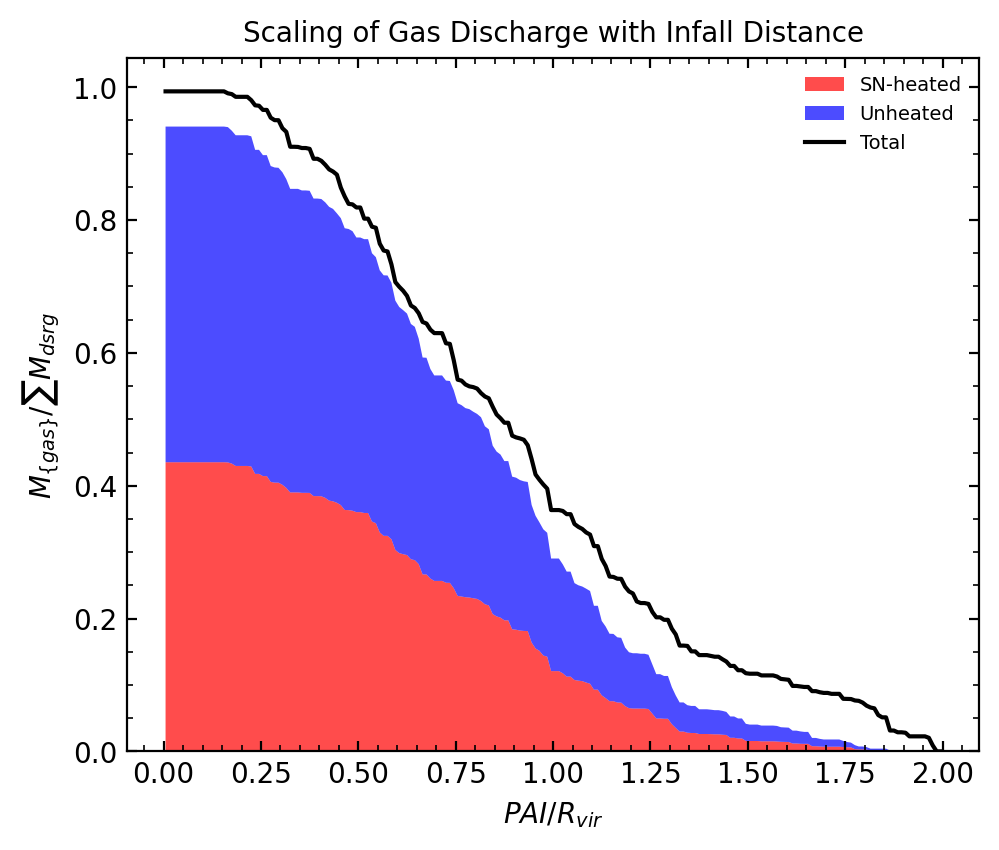

In [32]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_reac = reaccreted[reaccreted.sneHeated==False]


bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,cold_dsrg), 
                   range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

### SN-heated, Discharged Gas / SN-heated Gass #1 <a class="anchor" id="discharged"></a>
___

Plotting Proportion of SN-heated gas discharged per all SN-heated gas at each PAI.

In [12]:
# reading in all SN-heated gas (both discharged and not).
sntotal = pd.DataFrame()

keys = get_keys()

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    sntotal1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/sngas_particles.hdf5', key=key)
    sntotal1['key'] = key
    sntotal = pd.concat([sntotal, sntotal1])

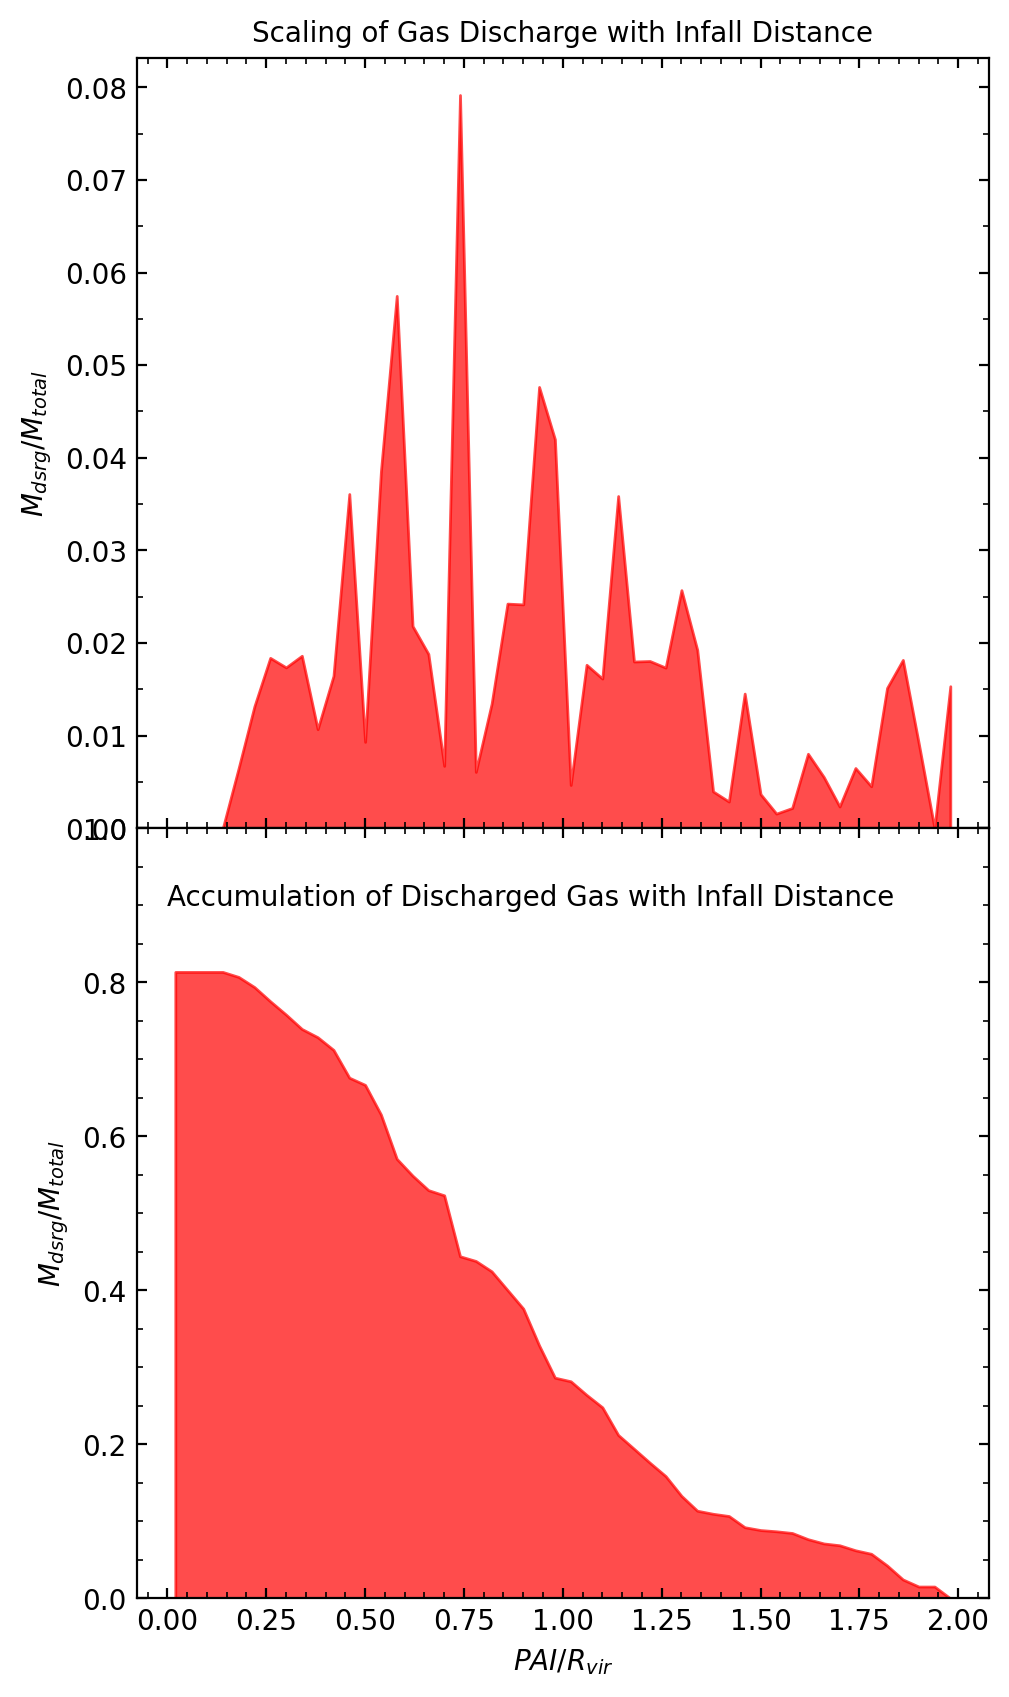

In [15]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


bins = 50
fig = plt.figure(dpi=200, figsize=(5.5,10))
gs = fig.add_gridspec(2,hspace=0)
ax = gs.subplots(sharex=True)
ax = ax.flatten()

y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, sntotal),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)

ax[0].stackplot(bincenters, y1, alpha=0.7, color='r')         

ax[1].stackplot(bincenters, sum1[-1]-sum1, alpha=0.7, color='r')    

ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


ax[0].set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax[0].set_xlabel(r'$PAI / R_{vir}$')
ax[0].set_ylabel('$M_{dsrg} / M_{total}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
# ax.grid(alpha=0.1, zorder=-1000)

# ax[1].set_title('Accumulation of Discharged Gas with Infall Distance', fontsize='medium')
ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_ylabel('$M_{dsrg} / M_{total}$')
ax[1].set_ylim(0,1)
                                                                                    
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.show()

In [80]:
# percent of sn gas discharged vs. percent discharged at each pai.

## Fractions of Rates <a class="anchor" id="other"></a>
___
___

### Reaccretion / Discharged <a class="anchor" id="other"></a>
___

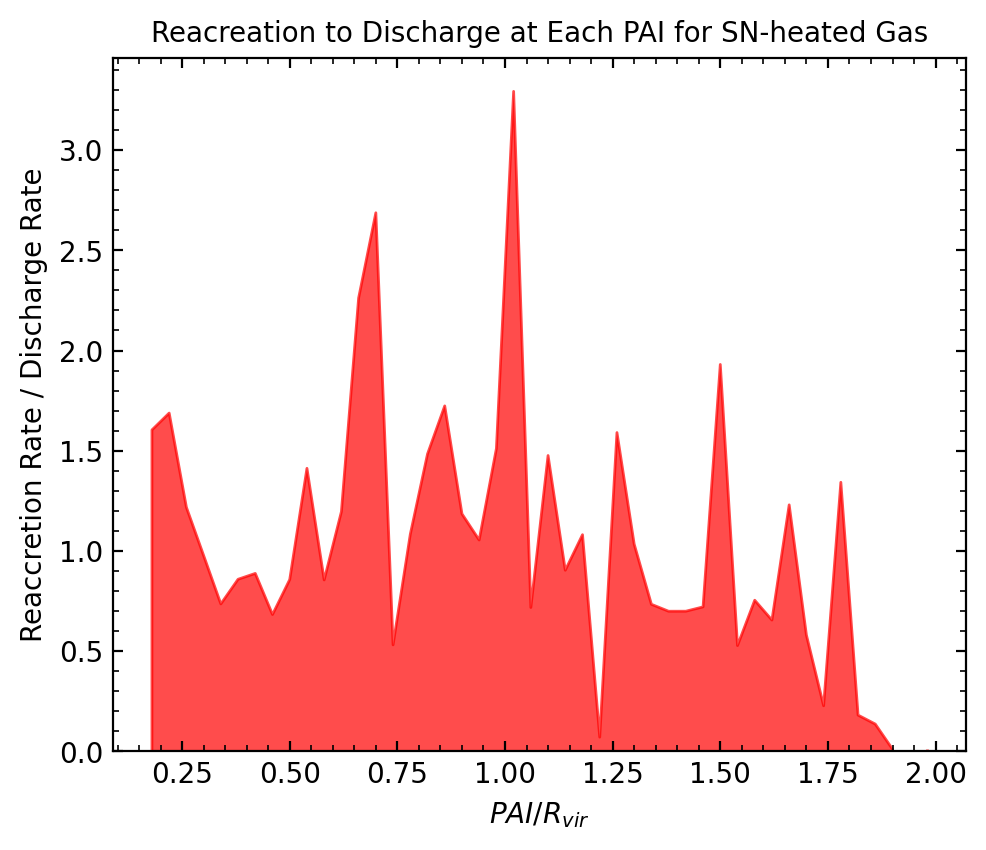

In [125]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


bins = 50
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax.stackplot(bincenters, y2/y1, alpha=0.7, color='r')         

ax.set_title('Reacreation to Discharge at Each PAI for SN-heated Gas',
             fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('Reaccretion Rate / Discharge Rate')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
# ax.grid(alpha=0.1, zorder=-1000)

plt.show()

## Other
___
___

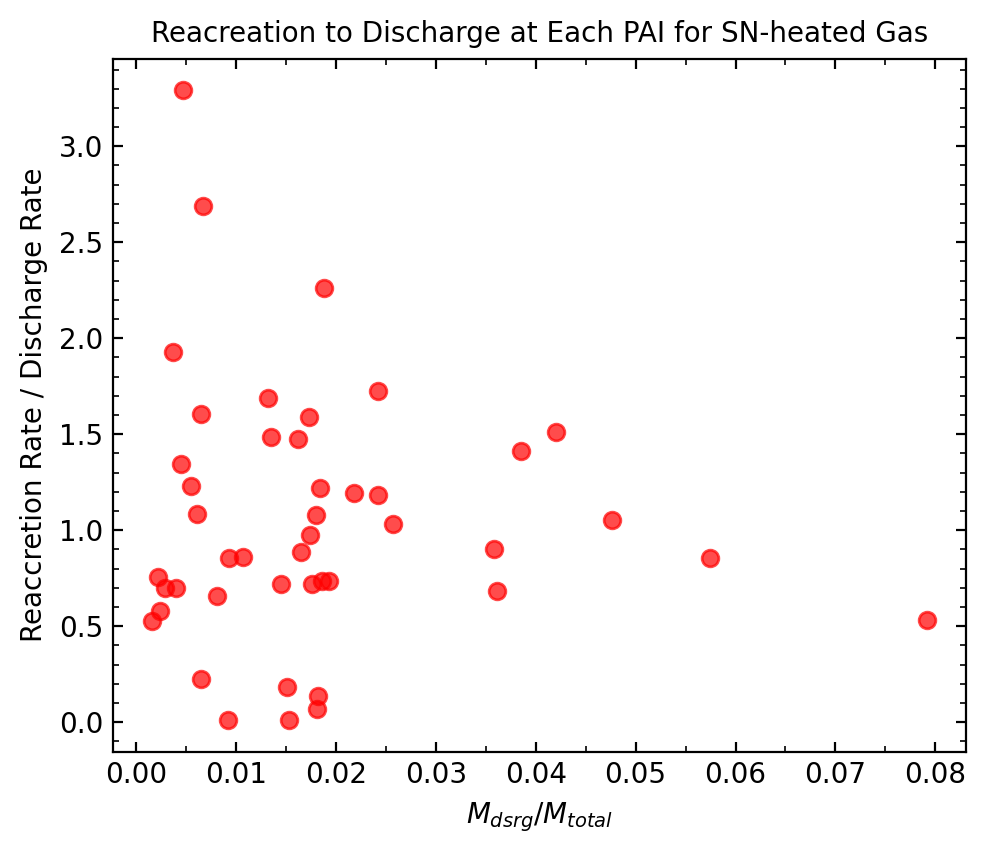

In [128]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


bins = 50
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac),
                     range=(0, 2))
sum2 = np.cumsum(y2)

y3, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, sntotal),
                     range=(0, 2))

ax.scatter(y3, y2/y1, alpha=0.7, color='r')         

ax.set_title('Reacreation to Discharge at Each PAI for SN-heated Gas',
             fontsize='medium')
ax.set_xlabel(r'$M_{dsrg} / M_{total}$')
ax.set_ylabel('Reaccretion Rate / Discharge Rate')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
# ax.grid(alpha=0.1, zorder=-1000)

plt.show()

### Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.

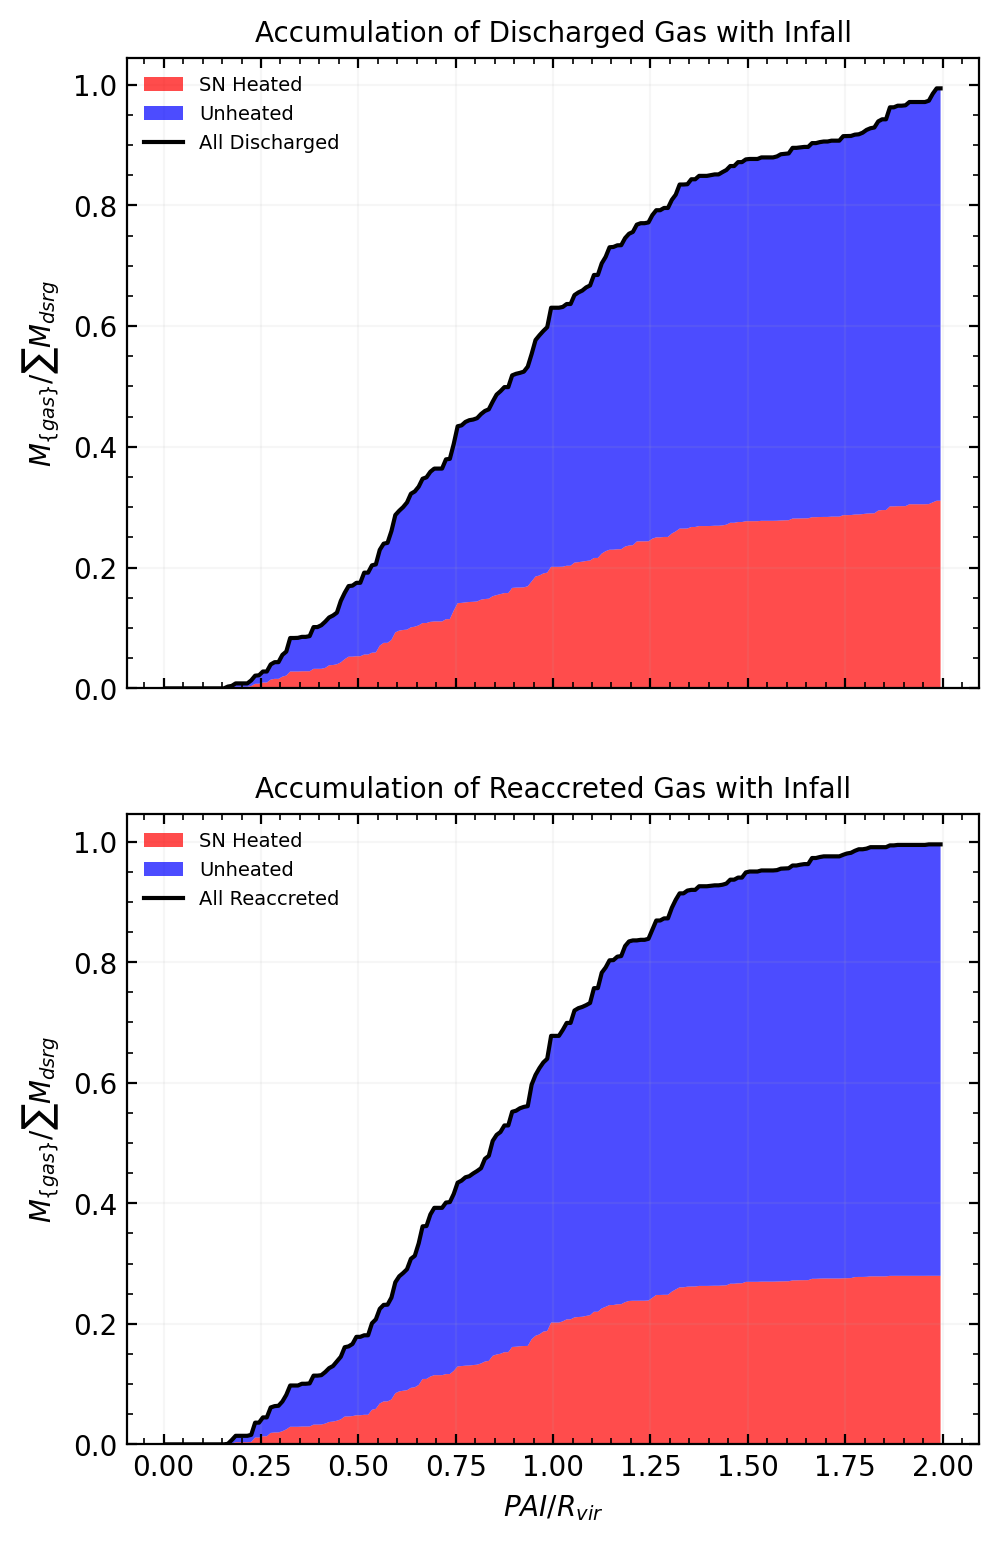

In [10]:
# Basic visualization of discharged/reaccreted gas as a function of POI.

hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

bins = 200
fig, ax = plt.subplots(2,1, dpi=200, figsize=(5.5,9), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax[0].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[0].plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

# y4, x = np.histogram(pai(hot)/len(discharged), bins=bins, weights=wt(hot,discharged), range=(0, 2))
# ax.plot(bincenters, y4, alpha=1.0, c='black', label='All Discharged')

ax[0].set_title('Accumulation of Discharged Gas with Infall', fontsize='medium')
# ax[0].set_xlabel(r'$PAI / R_{vir}$')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[0].set_xlim(-0.1,4)
# ax[0].set_ylim(0,0.2)

ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].grid(alpha=0.1, zorder=-1000)

ax[0].legend(frameon=False, fontsize=7)


hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted), range=(0, 2))
sum2 = np.cumsum(y2)
ax[1].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[1].plot(bincenters, sum3, alpha=1.0, c='black', label='All Reaccreted')

ax[1].set_title('Accumulation of Reaccreted Gas with Infall', fontsize='medium')
ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].grid(alpha=0.1, zorder=-1000)

ax[1].legend(frameon=False, fontsize=7)

plt.show()

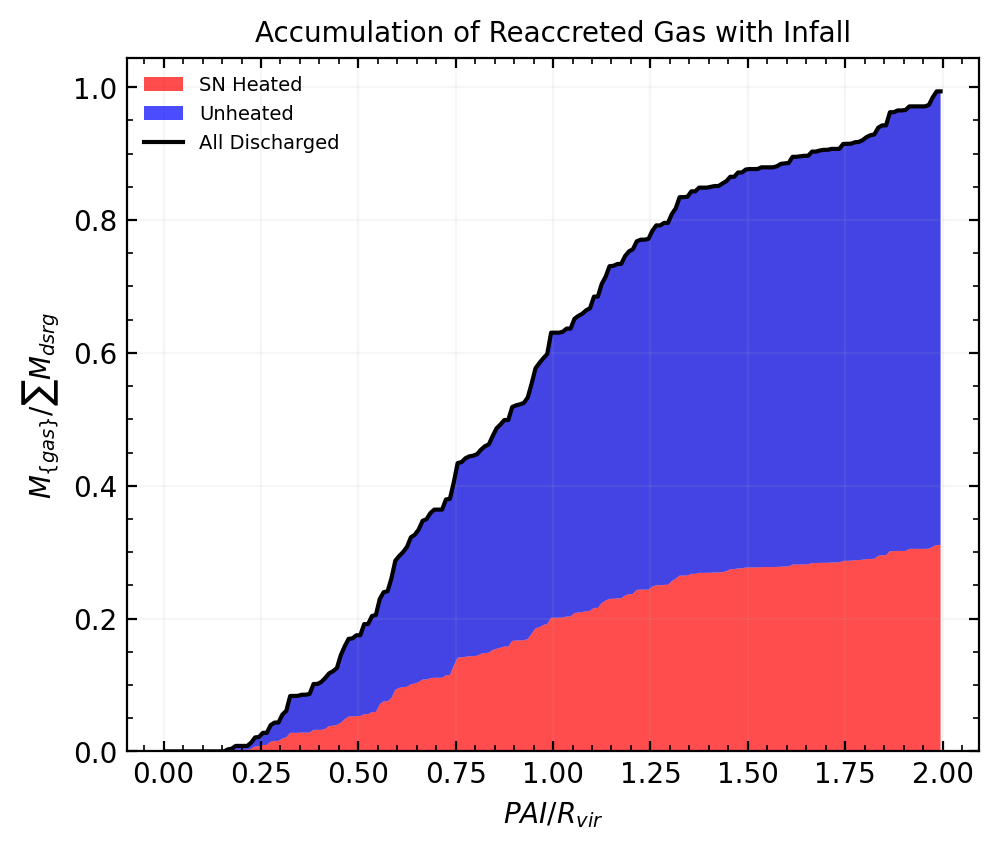

In [11]:
# Basic visualization of reaccreted gas as a function of POI.

hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

ax.fill_between(bincenters, sum1, sum3, color='k', ec=None, alpha=0.1)

ax.set_title('Accumulation of Reaccreted Gas with Infall', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

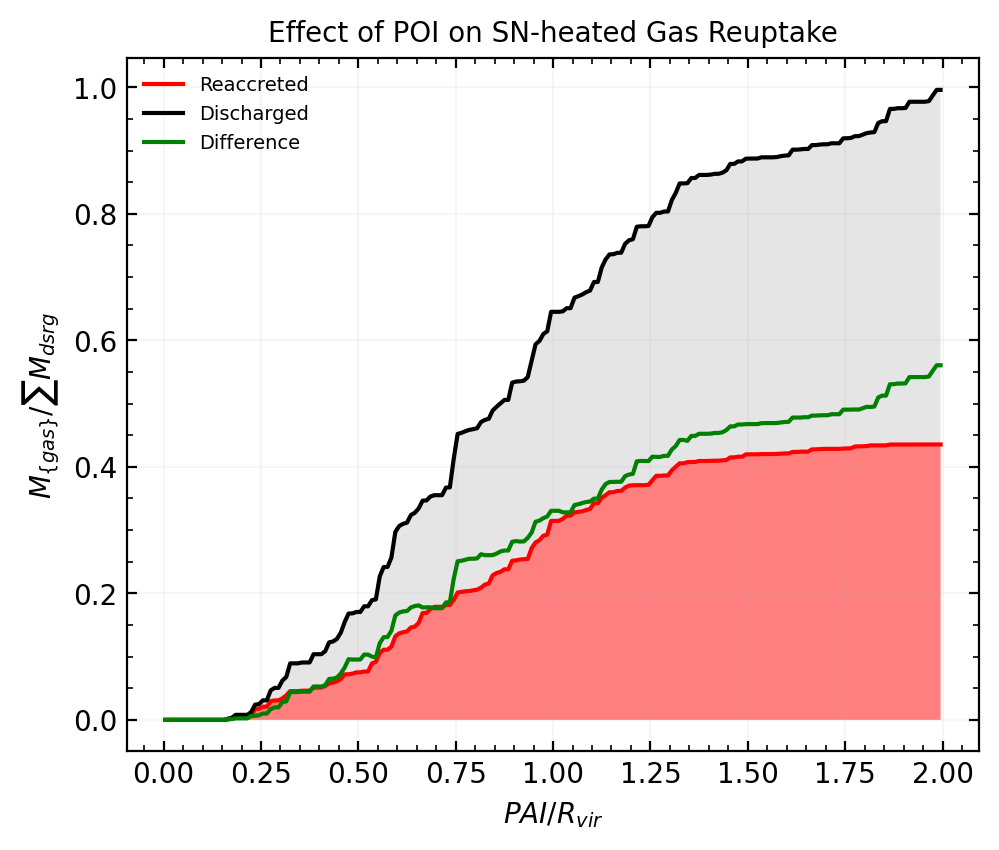

In [227]:
# Basic visualization of reaccreted gas as a function of POI.

hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_reac = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='red', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='r', ec=None, alpha=0.5)

y2, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

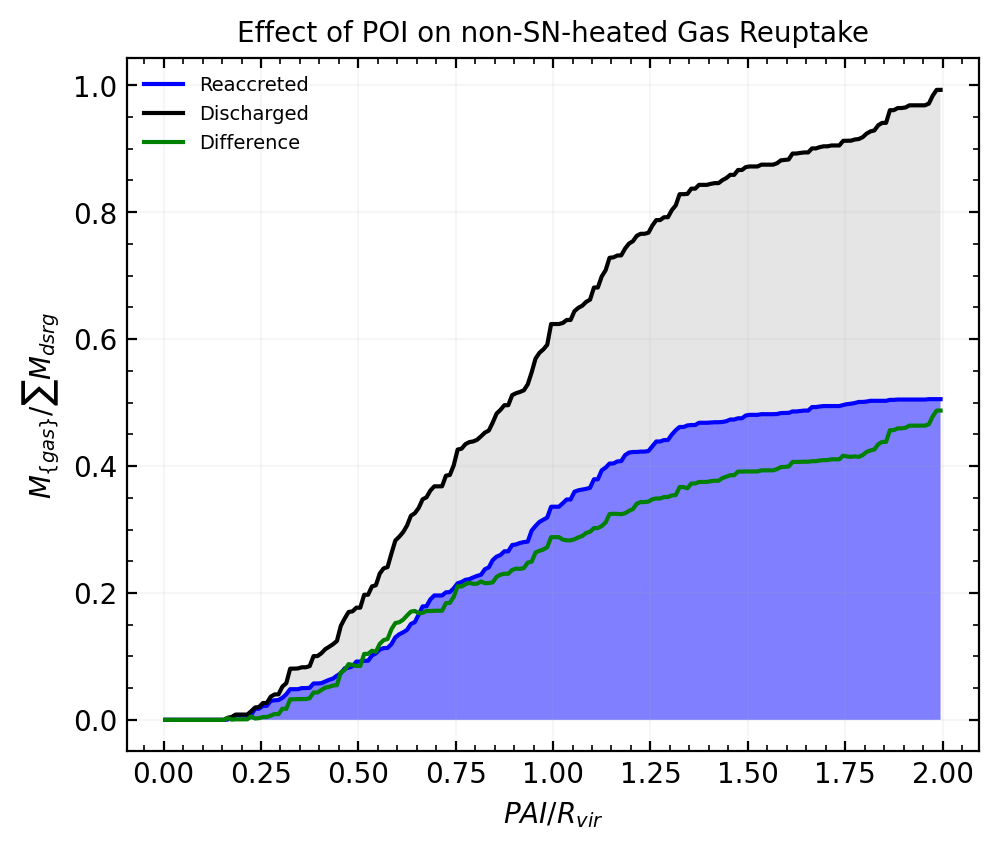

In [226]:
bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='b', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='b', ec=None, alpha=0.5)

y2, x = np.histogram(pai(cold_dsrg), bins=bins, weights=wt(cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on non-SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

Justifications for plot directions:
- Discharged:
    - 
- Reaccreted:
    - Is this a reasonable thing to plot against PAI?

This plot actually gives us a unique insight into reaccretion behaviors among the studied satellite galaxies:

- Namely, as satellites approach their host, reaccretions become nearly nonexistent -- contrasting with satellites at 2.00 $PAI/R_{vir}$ recollecting ~45% of their SN-heated, discharged gas.

In [ ]:
ax.plot(bincenters, (sum1[-1]-sum1) / (sum2[-1]-sum2), alpha=1.0, c='g', label='% Reaccreted') # NEEED TO CHANGE TO MASS REACCRETED / MASS DISCHARGED


In [9]:
# collecting mass reaccreted / mass discharged densities.

bins = np.linspace(0, 2, 200)

retention = []

for i in bins:
    retention.append(hot_reacc['mass']/hot_dsrg['mass'])

NameError: name 'hot_reacc' is not defined

In [11]:
# gas retention per PAI:
# essentially, mass reaccreted / mass discharged at each PAI.

hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reacc = reaccreted[reaccreted.sneHeated==True]
cold_reacc = reaccreted[reaccreted.sneHeated==False]

hot_dsrg['pai'] = pai(hot_dsrg)
hot_reacc['pai'] = pai(hot_reacc)

bins=200
y1, x1 = np.histogram(hot_reacc['pai'], bins=bins, range=(0, 2))

retention = []

# for i in len(x):
#     retention append reacc/ dsrg mass in bin





# reacc = np.asarray(hot_reacc['mass'])
# dsrg = np.asarray(hot_dsrg['mass'])

# bins=200
# y1, x1 = np.histogram(hot_reacc['mass'], bins=bins, range=(0, 2))
# # y2, x2 = np.histogram(dsrg, bins=bins, range=(0, 2))


# # bincenters = 0.5*(x[1:] + x[:-1])


# y1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


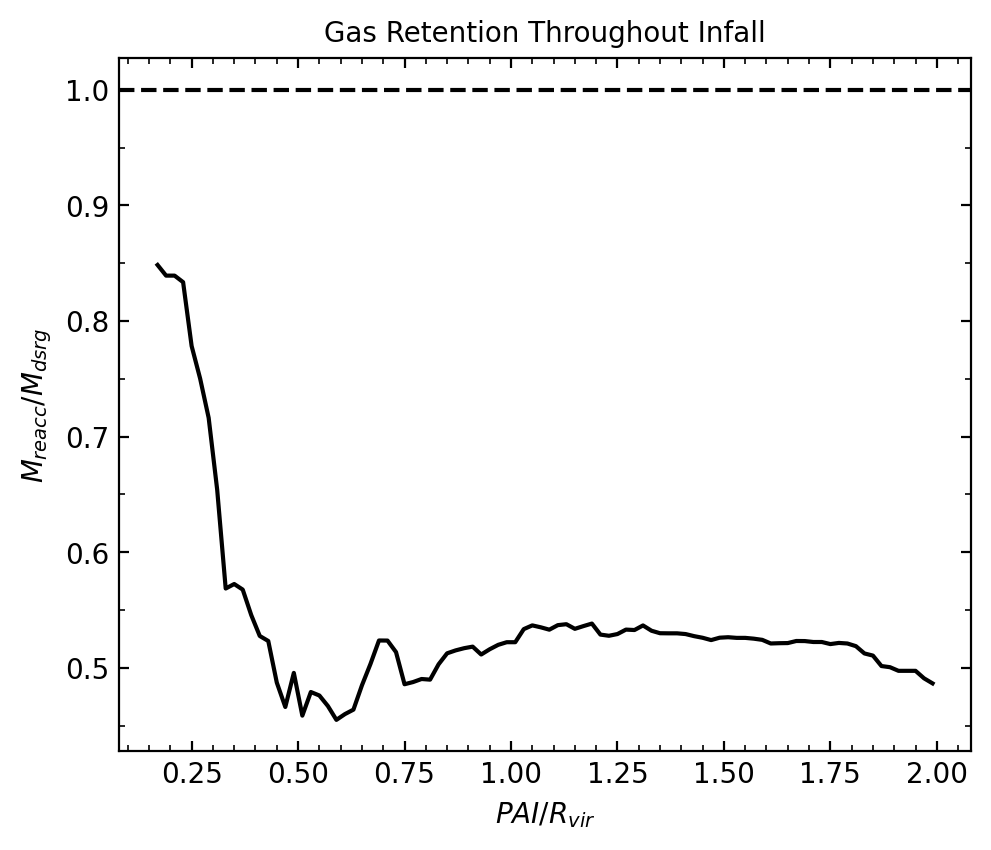

In [151]:
# gas retention per PAI:
# essentially, mass reaccreted / mass discharged at each PAI.
hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reacc = reaccreted[reaccreted.sneHeated==True]
cold_reacc = reaccreted[reaccreted.sneHeated==False]

bins = 100
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x1 = np.histogram(pai(discharged), bins=bins, weights=discharged['mass'], range=(0, 2))
bincenters = 0.5*(x1[1:] + x1[:-1])
sum1 = np.cumsum(y1)

y2, x2 = np.histogram(pai(reaccreted), bins=bins, weights=reaccreted['mass'], range=(0, 2))
sum2 = np.cumsum(y2)
ax.plot(bincenters,sum2/sum1, alpha=1.0, c='k')


# y3, x3 = np.histogram(pai(cold_dsrg), bins=bins, range=(0, 2))
# sum3 = np.cumsum(y3)
# y4, x4 = np.histogram(pai(cold_reacc), bins=bins, range=(0, 2))
# sum4 = np.cumsum(y4)
# ax.plot(bincenters, y4/y3, alpha=1.0, c='b', label='Unheated')

# placing horizontal at 1.00:
ax.axhline(y=1.0, color='black', linestyle='--')

ax.set_title('Gas Retention Throughout Infall', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{reacc} / M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

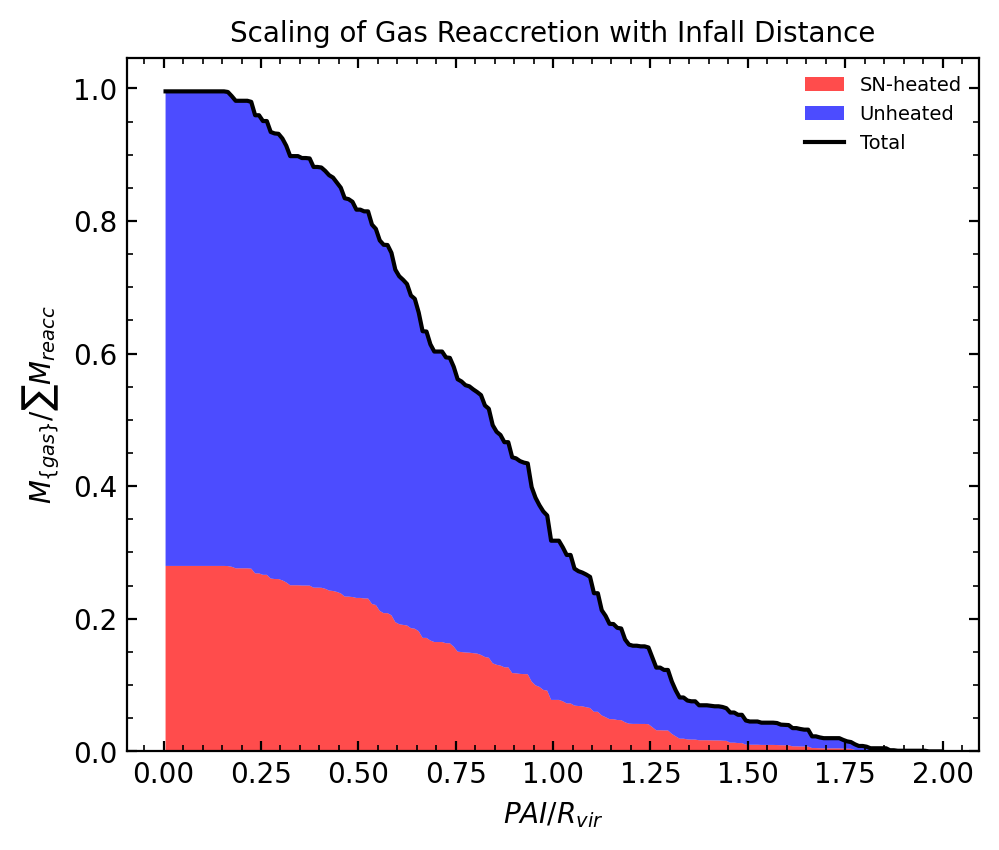

In [12]:
# so we could do % of gas mass discharged at different PAI, and % mass discharged as we
# close in the host galaxy's center.


hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted), range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')









ax.set_title('Scaling of Gas Reaccretion with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{reacc}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()